## Models for  Auto MPG Data set

###  Model 1 (as in Kaggle.com)

- missing values for `horsepower` replaced with mean of `horsepower`.
- all columns are numbers.

## Import libraries/packages

In [1]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##################################

### ML Models ###
from sklearn.linear_model import LinearRegression
from sklearn import tree
# from sklearn.tree import export_text
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

##################################

### Metrics ###
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [2]:
# Read the data from the auto-mpg_data-original.csv file.
ds = pd.read_csv("auto-mpg_data-original.csv")

In [3]:
# Examine the data types and the number of non-null items.
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     406 non-null    float64
 2   displacement  406 non-null    float64
 3   horsepower    400 non-null    float64
 4   weight        406 non-null    float64
 5   acceleration  406 non-null    float64
 6   model year    406 non-null    float64
 7   origin        406 non-null    float64
 8   car name      406 non-null    object 
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


In [4]:
# Display the shape of the data.
print("The data frame has {} rows and {} columns.".format(
    ds.shape[0], ds.shape[1]))

The data frame has 406 rows and 9 columns.


In [5]:
# Statistics for the data set.
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.50,23.0,29.000,46.6
cylinders,406.0,5.475369,1.712160,3.0,4.00,4.0,8.000,8.0
displacement,406.0,194.779557,104.922458,68.0,105.00,151.0,302.000,455.0
horsepower,400.0,105.082500,38.768779,46.0,75.75,95.0,130.000,230.0
weight,406.0,2979.413793,847.004328,1613.0,2226.50,2822.5,3618.250,5140.0
acceleration,406.0,15.519704,2.803359,8.0,13.70,15.5,17.175,24.8
model year,406.0,75.921182,3.748737,70.0,73.00,76.0,79.000,82.0
origin,406.0,1.568966,0.797479,1.0,1.00,1.0,2.000,3.0


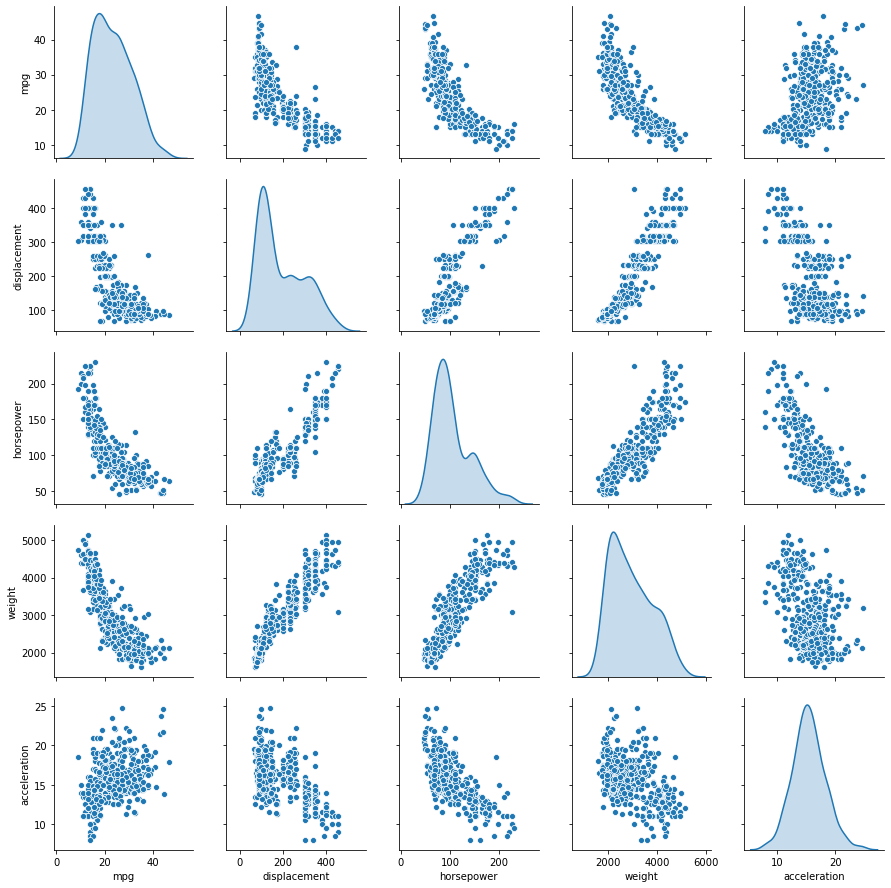

In [6]:
sns.pairplot(ds.drop(['cylinders','origin','model year','car name'], axis=1),diag_kind='kde')

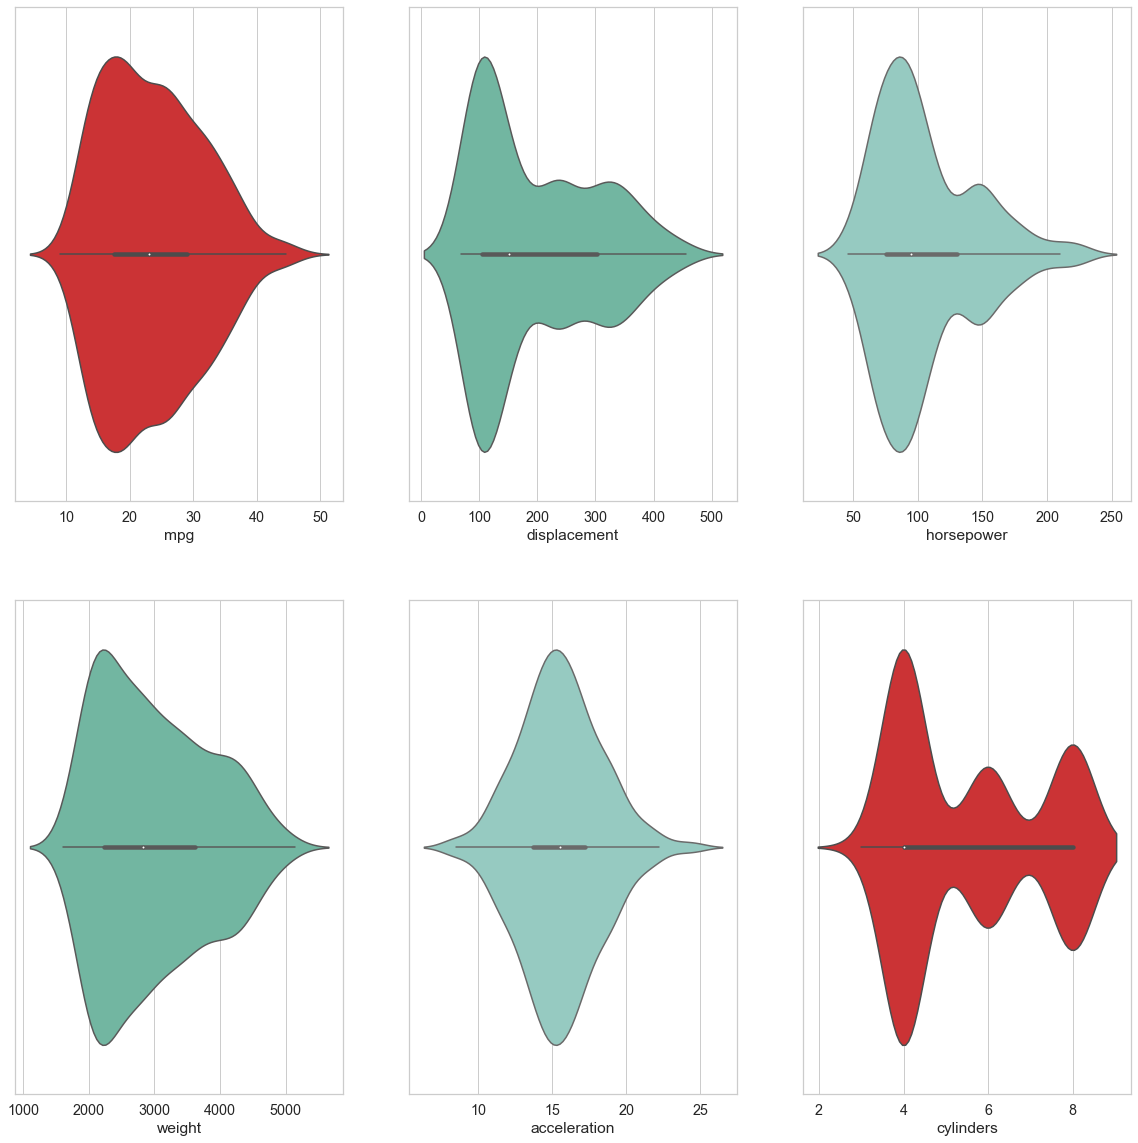

In [32]:
sns.set(context='notebook', style='whitegrid',
        font='sans-serif', font_scale=1.3)

f, axes = plt.subplots(2, 3, figsize=(20, 20), facecolor='white')
# f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.violinplot(ds['mpg'],  palette="Set1", ax=axes[0, 0])
ax2 = sns.violinplot(ds['displacement'], palette="Set2", ax=axes[0, 1])
ax3 = sns.violinplot(ds['horsepower'], palette="Set3", ax=axes[0, 2])
ax4 = sns.violinplot(ds['weight'], palette="Set2", ax=axes[1, 0])
ax5 = sns.violinplot(ds['acceleration'], palette="Set3", ax=axes[1, 1])
ax6 = sns.violinplot(ds['cylinders'], palette="Set1", ax=axes[1, 2])

In [6]:
# Check for duplicate rows.
print(f"There are {ds.duplicated().sum()} duplicate rows in the data set.")

There are 0 duplicate rows in the data set.


In [7]:
# Number of null values for each attribute.
ds.isnull().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

The rows with a null value from the `mpg` attribute can be seen below:

In [8]:
# Rows with null value at the "mpg" column.
ds[ds['mpg'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,NaN,4.0,133.0,115.0,3090.0,17.5,70.0,2.0,citroen ds-21 pallas
11,NaN,8.0,350.0,165.0,4142.0,11.5,70.0,1.0,chevrolet chevelle concours (sw)
12,NaN,8.0,351.0,153.0,4034.0,11.0,70.0,1.0,ford torino (sw)
13,NaN,8.0,383.0,175.0,4166.0,10.5,70.0,1.0,plymouth satellite (sw)
14,NaN,8.0,360.0,175.0,3850.0,11.0,70.0,1.0,amc rebel sst (sw)
17,NaN,8.0,302.0,140.0,3353.0,8.0,70.0,1.0,ford mustang boss 302
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117
367,NaN,4.0,121.0,110.0,2800.0,15.4,81.0,2.0,saab 900s


The above rows provide no usefull information because the class attribute value is missing. Hence, we cannot use them as a training nor a test set for our model, so they will be removed them from the dataset. For now, we store them for a potential future use.

In [9]:
# Store rows with a missing value at "mpg" attribute as a prediction set for future use.
prediction_set = ds[ds['mpg'].isnull()].drop('mpg', axis=1)

The rows with null values in the `horsepower` column can be seen below:

In [10]:
# Rows with null value at the "horsepower" column.
ds[ds['horsepower'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
133,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0,ford maverick
337,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0,renault lecar deluxe
343,23.6,4.0,140.0,NaN,2905.0,14.3,80.0,1.0,ford mustang cobra
361,34.5,4.0,100.0,NaN,2320.0,15.8,81.0,2.0,renault 18i
382,23.0,4.0,151.0,NaN,3035.0,20.5,82.0,1.0,amc concord dl


In [11]:
# Fill the null values of "horsepower" with the mean of "horsepower".
ds['horsepower'] = ds['horsepower'].fillna(ds['horsepower'].median())

In [12]:
# Remove rows from the data set with a null values.
new_ds = ds.dropna()

In [13]:
# Information about the new "clean" data set.
new_ds.info()

# Display the shape of the data.
print("\nThe new data frame has {} rows and {} columns.".format(
    new_ds.shape[0], new_ds.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null float64
displacement    398 non-null float64
horsepower      398 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null float64
origin          398 non-null float64
car name        398 non-null object
dtypes: float64(8), object(1)
memory usage: 31.1+ KB

The new data frame has 398 rows and 9 columns.


In [14]:
# Statistics for the new data set.
new_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,104.326633,38.216655,46.0,76.000,95.0,125.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


<Figure size 1440x1440 with 0 Axes>

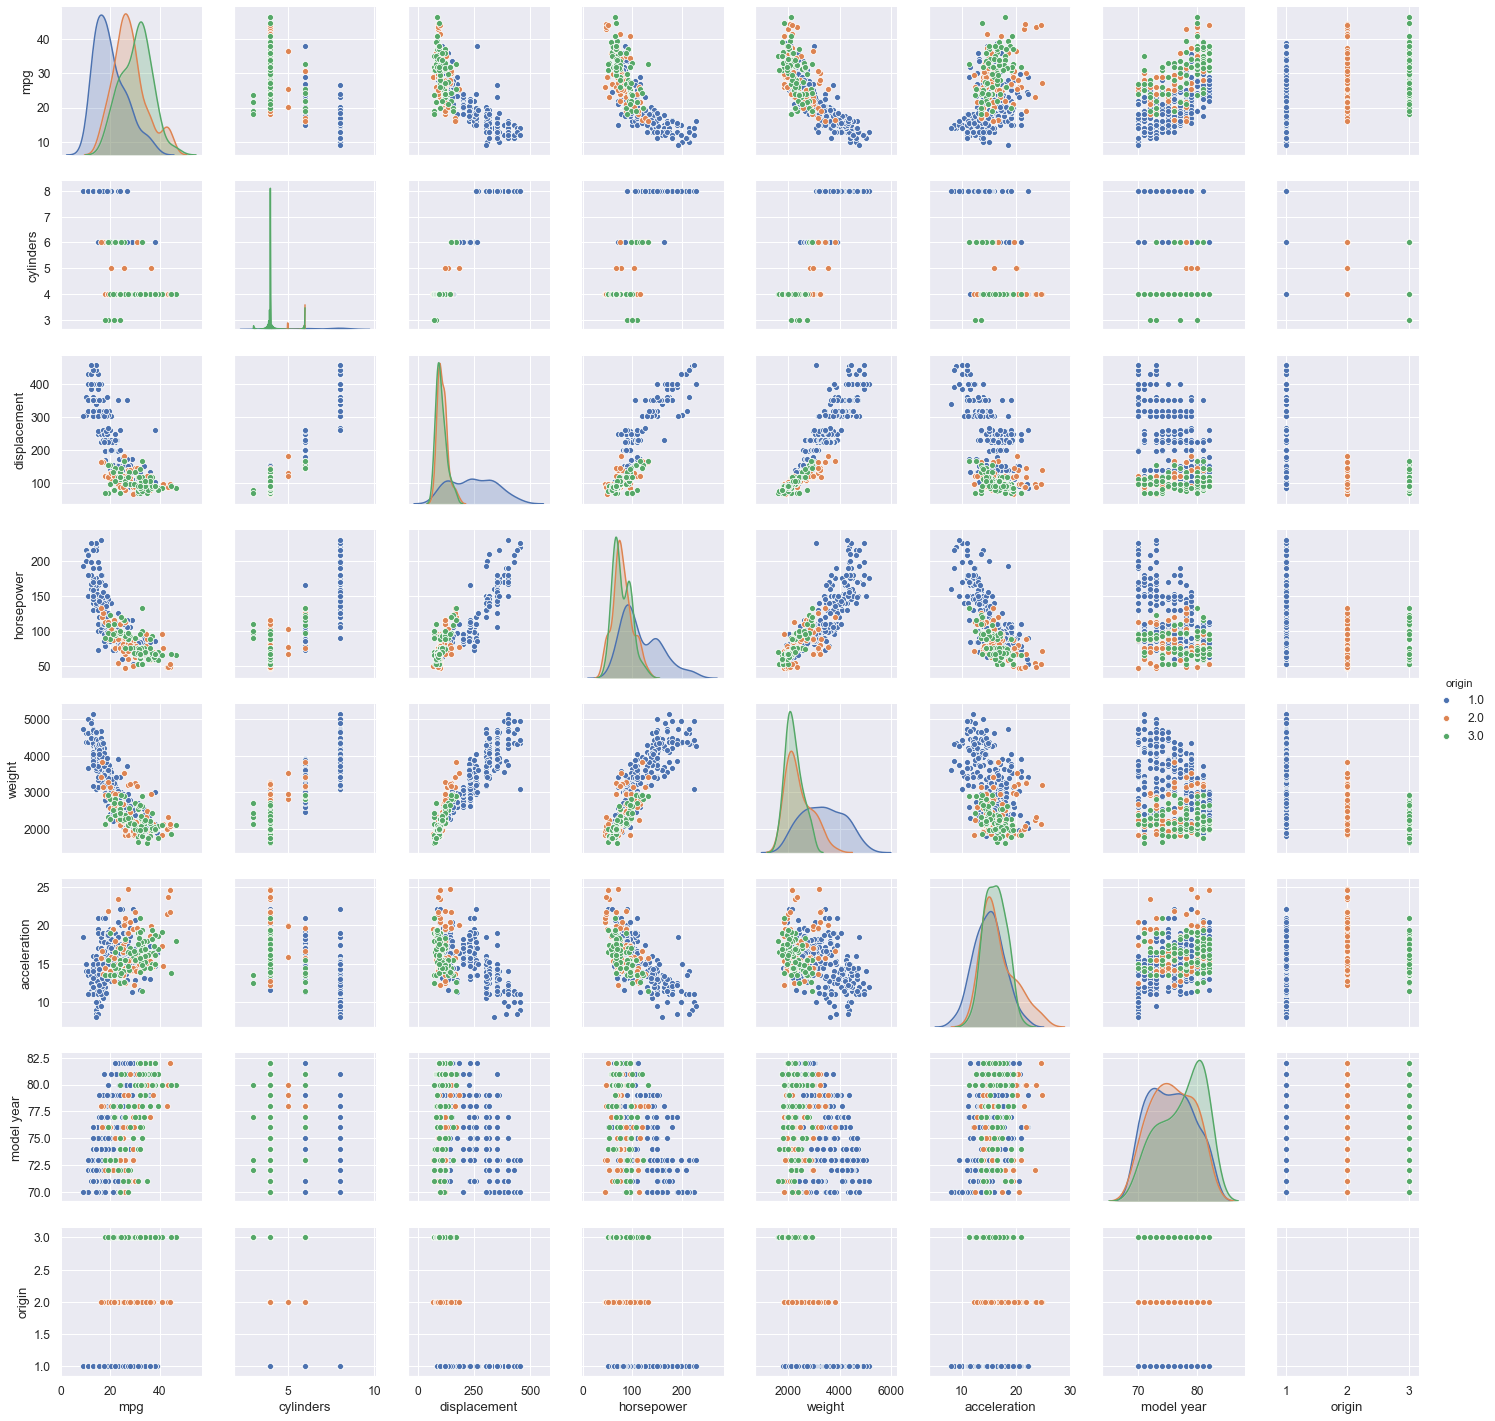

In [15]:
# Plotting a pairplot for the new data set.
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.1)
sns.pairplot(data=new_ds, diag_kind='kde', hue='origin')
plt.show()

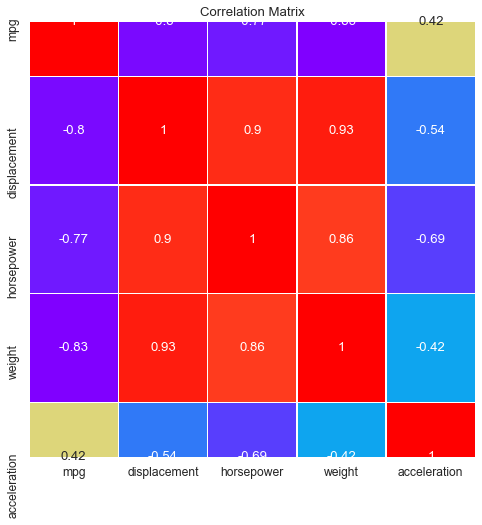

In [18]:
# Plotting a correlation heatmap for the new data set.
corr = new_ds[['mpg','displacement','horsepower','weight','acceleration']].corr()
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.1)
sns.heatmap(data=corr, annot=True, cbar=False, cmap='rainbow', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

In [7]:
corrs = new_ds[['mpg', 'displacement',
                'horsepower', 'weight', 'acceleration']].corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True, colorscale=[[0.0, "rgb(165,0,38)"],
                                [0.1111111111111111, "rgb(215,48,39)"],
                                [0.2222222222222222, "rgb(244,109,67)"],
                                [0.3333333333333333, "rgb(253,174,97)"],
                                [0.4444444444444444, "rgb(254,224,144)"],
                                [0.5555555555555556, "rgb(224,243,248)"],
                                [0.6666666666666666, "rgb(171,217,233)"],
                                [0.7777777777777778, "rgb(116,173,209)"],
                                [0.8888888888888888, "rgb(69,117,180)"],
                                [1.0, "rgb(49,54,149)"]])
figure.show()

NameError: name 'new_ds' is not defined

## Part 2: Preproccesing
In this part we prepare the data for our models. This means that we choose the columns that will be our independed variables and which column the target that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [18]:
# Distinguish attribute columns and target column.
X = new_ds[new_ds.columns[1:-1]]
y = new_ds['mpg']

In [19]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25)

In [20]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling
In this section we build and try 3 models:
- Linear Regression
- Decision tree
- Neural network

Each model will be trained and make a prediction for the test set. Accuracy, precision, recall, f1-score, confusion matrix and ROC will be calculated for each model. Then we will use the GridSearchCV module to tune our models and search for the best hyperparameters in order to increase the accuracy of each model.

In [21]:
# Score metrics
scores = ['neg_mean_absolute_error', 'neg_mean_squared_error']

## Linear Regression

In [22]:
# Initialize a Logistic Regression estimator.
linreg = LinearRegression(n_jobs=-1)

# Train the estimator.
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [23]:
# Make predictions.
lin_pred = linreg.predict(X_test)

# Calculate CV.
cv_lin_reg = cross_validate(linreg, X, y, scoring=scores, cv=10, n_jobs=-1)

## Linear Regression Metrics

In [24]:
# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" %
      mean_absolute_error(y_test, lin_pred))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, lin_pred))

# Mean root squared error (relative error).
print("Mean root squared error (RMSE): %.2f" %
      np.sqrt(mean_squared_error(y_test, lin_pred)))

# Cross-Validation MAE
print('Cross-validation MAE: %0.2f' %
      (abs(cv_lin_reg['test_neg_mean_absolute_error'].mean())))

# Cross-Validation MSE
print('Cross-validation MSE: %.2f' %
      (abs(cv_lin_reg['test_neg_mean_squared_error'].mean())))

# Cross-Validation MSE
print('Cross-validation RMSE: %.2f' %
      (np.sqrt(abs(cv_lin_reg['test_neg_mean_squared_error'].mean()))))

Mean absolute error (MAE): 2.57
Mean squared error (MSE): 11.29
Mean root squared error (RMSE): 3.36
Cross-validation MAE: 2.75
Cross-validation MSE: 12.90
Cross-validation RMSE: 3.59


## Decision tree

In [25]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeRegressor(max_depth=30, random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=30,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=25, splitter='best')

Text(0.5, 1.0, 'Decision Tree')

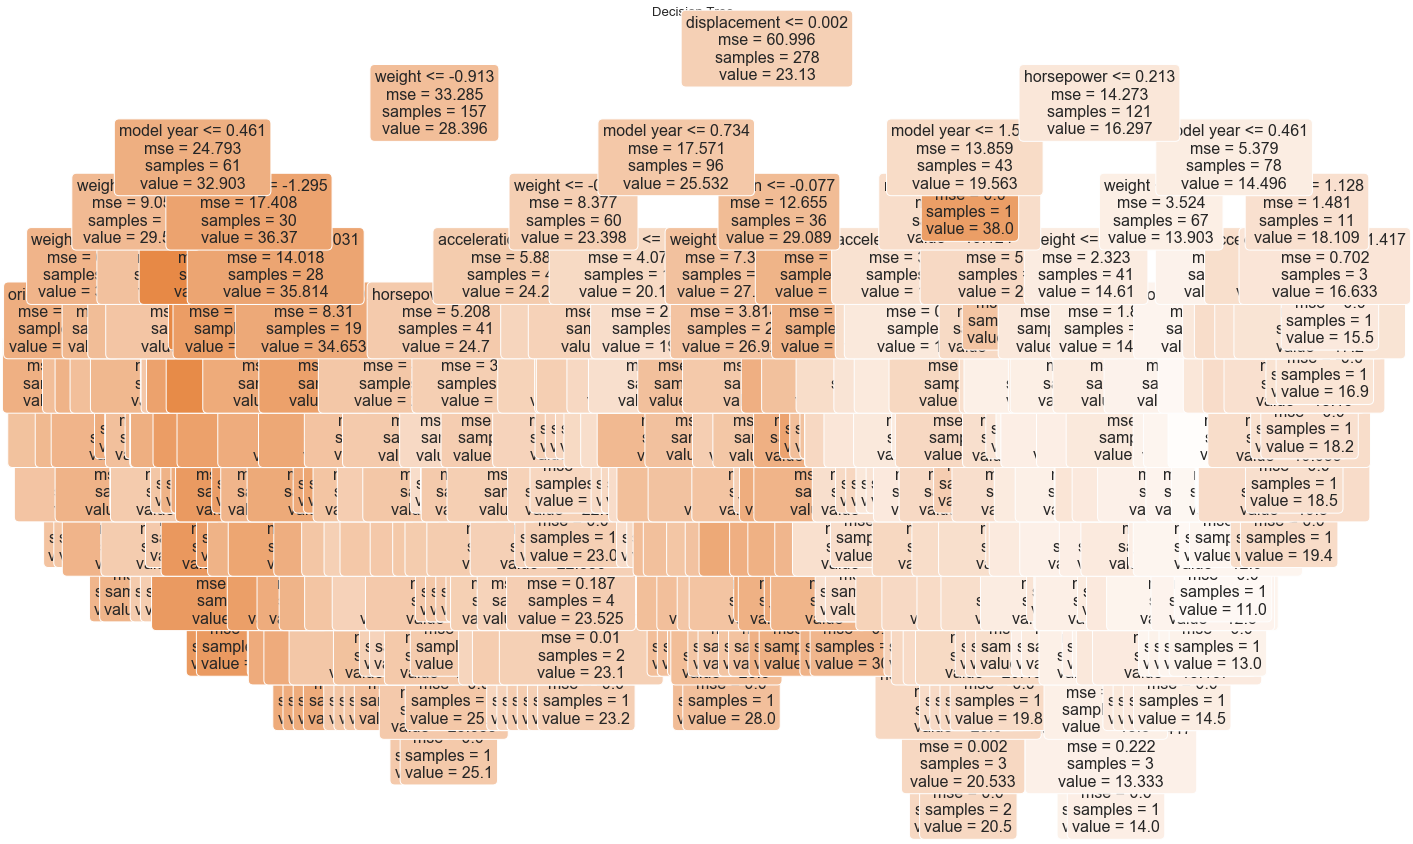

In [26]:
# Plot the tree.
fig = plt.figure(figsize=(23, 15))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [27]:
# Print the tree in a simplified version.
r = tree.export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- displacement <= 0.00
|   |--- weight <= -0.91
|   |   |--- model year <= 0.46
|   |   |   |--- weight <= -1.11
|   |   |   |   |--- weight <= -1.35
|   |   |   |   |   |--- origin <= 1.18
|   |   |   |   |   |   |--- value: [36.00]
|   |   |   |   |   |--- origin >  1.18
|   |   |   |   |   |   |--- weight <= -1.58
|   |   |   |   |   |   |   |--- value: [35.00]
|   |   |   |   |   |   |--- weight >  -1.58
|   |   |   |   |   |   |   |--- weight <= -1.41
|   |   |   |   |   |   |   |   |--- value: [31.00]
|   |   |   |   |   |   |   |--- weight >  -1.41
|   |   |   |   |   |   |   |   |--- value: [33.00]
|   |   |   |   |--- weight >  -1.35
|   |   |   |   |   |--- origin <= 1.18
|   |   |   |   |   |   |--- weight <= -1.18
|   |   |   |   |   |   |   |--- acceleration <= -0.24
|   |   |   |   |   |   |   |   |--- value: [29.00]
|   |   |   |   |   |   |   |--- acceleration >  -0.24
|   |   |   |   |   |   |   |   |--- horsepower <= -1.08
|   |   |   |   |   |   |   |   |   |--- v

In [28]:
# Make predictions.
tr_pred = tr.predict(X_test)

# Calculate CV.
cv_tr_reg = cross_validate(tr, X, y, scoring=scores, cv=10, n_jobs=-1)

## Decision tree Metrics

In [29]:
# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" %
      mean_absolute_error(y_test, tr_pred))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, tr_pred))

# Mean root squared error (relative error).
print("Mean root squared error (RMSE): %.2f" %
      np.sqrt(mean_squared_error(y_test, tr_pred)))

# Cross-Validation MAE
print('Cross-validation MAE: %0.2f' %
      (abs(cv_tr_reg['test_neg_mean_absolute_error'].mean())))

# Cross-Validation MSE
print('Cross-validation MSE: %.2f' %
      (abs(cv_tr_reg['test_neg_mean_squared_error'].mean())))

# Cross-Validation MSE
print('Cross-validation RMSE: %.2f' %
      (np.sqrt(abs(cv_tr_reg['test_neg_mean_squared_error'].mean()))))

Mean absolute error (MAE): 2.37
Mean squared error (MSE): 12.70
Mean root squared error (RMSE): 3.56
Cross-validation MAE: 2.91
Cross-validation MSE: 16.14
Cross-validation RMSE: 4.02


## Neural network (MLP)

In [30]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPRegressor(max_iter=1000, random_state=25, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=25, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [31]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# Calculate CV
cv_mlp_reg = cross_validate(mlp, X, y, scoring=scores, cv=10, n_jobs=-1)

## Neural network (MLP) metrics

In [32]:
# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" %
      mean_absolute_error(y_test, mlp_pred))

# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, mlp_pred))

# Mean root squared error (relative error).
print("Mean root squared error (RMSE): %.2f" %
      np.sqrt(mean_squared_error(y_test, mlp_pred)))

# Cross-Validation MAE
print('Cross-validation MAE: %0.2f' %
      (abs(cv_mlp_reg['test_neg_mean_absolute_error'].mean())))

# Cross-Validation MSE
print('Cross-validation MSE: %.2f' %
      (abs(cv_mlp_reg['test_neg_mean_squared_error'].mean())))

# Cross-Validation MSE
print('Cross-validation RMSE: %.2f' %
      (np.sqrt(abs(cv_mlp_reg['test_neg_mean_squared_error'].mean()))))

Mean absolute error (MAE): 1.75
Mean squared error (MSE): 6.88
Mean root squared error (RMSE): 2.62
Cross-validation MAE: 2.80
Cross-validation MSE: 14.25
Cross-validation RMSE: 3.78


## Results

In [33]:
metrics = ['MAE', 'MSE', 'RMSE', 'CV MAE', 'CV MSE', 'CV RMSE']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Linear Regression', x=metrics, y=[mean_absolute_error(y_test, lin_pred),
                                                   mean_squared_error(
                                                       y_test, lin_pred),
                                                   np.sqrt(mean_squared_error(
                                                       y_test, lin_pred)),
                                                   abs(cv_lin_reg['test_neg_mean_absolute_error'].mean(
                                                   )),
                                                   abs(cv_lin_reg['test_neg_mean_squared_error'].mean(
                                                   )),
                                                   np.sqrt(abs(cv_lin_reg['test_neg_mean_squared_error'].mean()))]),
    go.Bar(name='Decision Tree', x=metrics, y=[mean_absolute_error(y_test, tr_pred),
                                               mean_squared_error(
        y_test, tr_pred),
        np.sqrt(mean_squared_error(
            y_test, tr_pred)),
        abs(cv_tr_reg['test_neg_mean_absolute_error'].mean(
        )),
        abs(cv_tr_reg['test_neg_mean_squared_error'].mean(
        )),
        np.sqrt(abs(cv_tr_reg['test_neg_mean_squared_error'].mean()))]),
    go.Bar(name='Neural Network (MLP)', x=metrics, y=[mean_absolute_error(y_test, mlp_pred),
                                                      mean_squared_error(
        y_test, mlp_pred),
        np.sqrt(mean_squared_error(
            y_test, mlp_pred)),
        abs(cv_mlp_reg['test_neg_mean_absolute_error'].mean(
        )),
        abs(cv_mlp_reg['test_neg_mean_squared_error'].mean(
        )),
        np.sqrt(abs(cv_mlp_reg['test_neg_mean_squared_error'].mean()))])
])

fig.update_layout(title_text='Results',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

In [34]:
d = {
    'Models': ['Linear Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'MAE': [mean_absolute_error(y_test, lin_pred), mean_absolute_error(y_test, tr_pred), mean_absolute_error(y_test, mlp_pred)],
    'MSE': [mean_squared_error(y_test, lin_pred), mean_squared_error(y_test, tr_pred), mean_squared_error(y_test, mlp_pred)],
    'RMSE': np.sqrt([mean_squared_error(y_test, lin_pred), mean_squared_error(y_test, tr_pred), mean_squared_error(y_test, mlp_pred)]),
    'CV MAE': [abs(cv_lin_reg['test_neg_mean_absolute_error'].mean()), abs(cv_tr_reg['test_neg_mean_absolute_error'].mean()), abs(cv_mlp_reg['test_neg_mean_absolute_error'].mean())],
    'CV MSE': [abs(cv_lin_reg['test_neg_mean_squared_error'].mean()), abs(cv_tr_reg['test_neg_mean_squared_error'].mean()), abs(cv_mlp_reg['test_neg_mean_squared_error'].mean())],
    'CV RMSE': np.sqrt([abs(cv_lin_reg['test_neg_mean_squared_error'].mean()), abs(cv_tr_reg['test_neg_mean_squared_error'].mean()), abs(cv_mlp_reg['test_neg_mean_squared_error'].mean())])

}

results = pd.DataFrame(data=d).round(3).set_index('Models')
results

,MAE,MSE,RMSE,CV MAE,CV MSE,CV RMSE
Models,,,,,,
Linear Regression,2.570,11.286,3.359,2.748,12.902,3.592
Decision Tree,2.368,12.703,3.564,2.914,16.136,4.017
Neural Network (MLP),1.752,6.876,2.622,2.802,14.255,3.776


## Quinlan's results

|                   | Mean squared error (MSE) | Mean absolute error (MAE) |
|-------------------|:------------------------:|:-------------------------:|
| Linear Regression |           19.4           |            2.61           |
| Decision tree     |           14.7           |            2.11           |
| Neural Network    |           12.5           |            2.02           |

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Mean Absolute Error $mae_{1}$ for model $M_{1}$ on test set $A$.
- Mean Absolute Error $mae_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|mae_{1}-mae_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.


In [35]:
from itertools import combinations

# Dictionary with all the Regressors.
models = {'LinearRegression': linreg,
          'DecisionTreeRegressor': tr,
          'MLPRegressor': mlp
          }


def evaluating_performance(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            mae1 = mean_absolute_error(
                y_test, models[model[0]].predict(X_test))
            mae2 = mean_absolute_error(
                y_test, models[model[1]].predict(X_test))
            var1 = np.var(models[model[0]].predict(X_test))
            var2 = np.var(models[model[1]].predict(X_test))
            n = len(X_test)
            P = abs(mae1-mae2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'The models {model[0]} and {model[1]} are significant different')

In [36]:
evaluating_performance(models)

Comparing Performance between LinearRegression and DecisionTreeRegressor: 0.221
There is no significant diferrence between LinearRegression and DecisionTreeRegressor

Comparing Performance between LinearRegression and MLPRegressor: 0.932
There is no significant diferrence between LinearRegression and MLPRegressor

Comparing Performance between DecisionTreeRegressor and MLPRegressor: 0.643
There is no significant diferrence between DecisionTreeRegressor and MLPRegressor



---